In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from pyod.models.knn import KNN

In [2]:
df = pd.read_csv("all_LAT_uns.csv")
data = df.copy(deep = True)

Ο στόχος της εργασίας είναι να ανιχνεύσουμε ακραίες στροφικές κινήσεις ενός οδηγού, με βάση τα δεδομένα που έχουμε από τους αισθητήρες του κινητού τηλεφώνου του. Επειδή δεν γνωρίζουμε τα labels των τιμών, ουσιαστικά έχουμε ένα unsupervised πρόβλημα να επιλύσουμε. Η έλλειψη γνώσης και διαίσθησης σχετικά με τα δεδομένα μας δυσκόλεψε ως προς την αντιμετώπιση του προβλήματος, καθώς θα κάνουμε διάφορες υποθέσεις σύμφωνα με την δική μας κρίση. Η ανίχνευση των outliers θα γίνει σε 2 στάδια.
<br> Αρχικά, θα χρησιμοποιήσουμε 6 αλγορίθμους για unsupervised outlier detection, ώστε να βρούμε τα πιθανά outliers. Αυτό θα γίνει ουσιαστικά με ένα voting ensemble όπως θα δούμε παρακάτω, δηλαδή αν τουλάχιστον 4 αλγόριθμοι κρίνουν ένα σημείο ως outlier τότε θα το καταγράφουμε τελικά ως έκπτωτη τιμή προς περαιτέρω μελέτη.
<br> Στο 2ο σκέλος, θα εφαρμόσουμε κάποιους κανόνες με βάση την διαίσθηση και την γνώση μας, έστω να καταλήξουμε μόνο στα outliers που υποδεικνύουν harsh cornering.

In [3]:
outlier_fraction = 0.05

Επιλέγουμε το contamination ίσο με 0.05 (5%), δηλαδή η αναλογία των outliers στο dataset. Αυτή η επιλογή είναι καθαρά διαισθητική και υπό την λογική του να πάρουμε περίπου 5000 τιμές ως outliers από τον κάθε αλγόριθμο, και μετέπειτα να εκτελέσουμε την διαδικασία του voting, για να κρατήσουμε όσα συμπέφτουν. Με 1 χαρακτηρίζονται οι κανονικές τιμές και με -1 χαρακτηρίζονται οι outliers.

## Isolation Forest

In [4]:
clf = IsolationForest(n_estimators = 200, contamination = outlier_fraction, warm_start = True)
iso_f = clf.fit(data)
df["anomaly_isof"] = iso_f.predict(data)

In [5]:
df["anomaly_isof"].value_counts()

 1    98696
-1     5195
Name: anomaly_isof, dtype: int64

## Local Outlier Factor (LOF)

In [6]:
clf = LocalOutlierFactor(contamination = outlier_fraction)
df["anomaly_lof"] = clf.fit_predict(data)

In [7]:
df["anomaly_lof"].value_counts()

 1    98696
-1     5195
Name: anomaly_lof, dtype: int64

## OneClassSVM

In [8]:
clf = OneClassSVM(gamma='auto', nu = 0.05)
df["anomaly_OCSVM"] = clf.fit_predict(data)

In [9]:
df["anomaly_OCSVM"].value_counts()

 1    98699
-1     5192
Name: anomaly_OCSVM, dtype: int64

Η παράμετρος nu ουσιαστικά δουλεύει όπως το contamination. Στην πραγματικότητα δίνει ένα άνω όριο του κλάσματος των training errors.

## EllipticEnvelope

In [10]:
cov = EllipticEnvelope(contamination = outlier_fraction)
df["anomaly_EE"] = cov.fit_predict(data)

In [11]:
df["anomaly_EE"].value_counts()

 1    98696
-1     5195
Name: anomaly_EE, dtype: int64

## DBSCAN

In [12]:
model = DBSCAN(
 eps = .18, 
 metric="euclidean",
 min_samples = 10,
 n_jobs = -1).fit(data)
df["anomaly_DBSCAN"] = model.labels_
df["anomaly_DBSCAN"].replace(0, 1, inplace = True) # fix values for inliers

In [13]:
df["anomaly_DBSCAN"].value_counts()

 1    98650
-1     5241
Name: anomaly_DBSCAN, dtype: int64

Ο αλγόριθμος DBSCAN δεν έχει contamination, οπότε ύστερα από δοκιμές καταλήξαμε στις τιμές που δίνουν περίπου ίδιο πλήθος outliers.

## KNN

In [14]:
clf = KNN(contamination = outlier_fraction)
clf.fit(data)
df["anomaly_KNN"] = clf.predict(data)

In [15]:
df["anomaly_KNN"].replace(1, -1, inplace = True) # fix values for outliers
df["anomaly_KNN"].replace(0, 1, inplace = True) # fix values for inliers

In [16]:
df["anomaly_KNN"].value_counts()

 1    99060
-1     4831
Name: anomaly_KNN, dtype: int64

In [17]:
df["final_outliers"] = 0
for i in range(7, 13):
    df["final_outliers"] += df.iloc[:, i]

In [18]:
df["final_outliers"].value_counts()

 6    93668
 4     3689
-4     1878
 2     1323
-6     1315
-2     1180
 0      838
Name: final_outliers, dtype: int64

Σε αυτό το σημείο ας εξηγήσουμε λίγο τι σημαίνουν οι παραπάνω τιμές. Κάθε αλγόριθμος ψηφίζει 1 αν θεωρεί μια τιμή inlier και -1 για outlier. Συνεπώς,: <br>
- 6  -> all (6) voted inlier <br>
- 4  -> 5 voted inlier - 1 voted outlier (5 - 1 = 4) <br>
- 2  -> 4 voted inlier - 2 voted outlier (4 - 2 = 2) <br>
- 0  -> 3 voted inlier - 3 voted outlier (3 - 3 = 0) <br>
- -2 -> 2 voted inlier - 4 voted outlier (2 - 4 = -2) (1180 values) <br>
- -4 -> 1 voted inlier - 5 voted outlier (1 - 5 = -4) (1878 values) <br>
- -6 -> all (6) voted outlier (1315 values)

Όπως αναφέραμε και στην αρχή, θα γίνει ένα ensemble voting μεταξύ των αλγοριθμών και θα κρατήσουμε μόνο τις τιμές που τουλάχιστον 4 αλγόριθμοι έκριναν ως outliers, συνεπώς κρατάμε τις τιμές για value -2, -4 και -6.

In [19]:
ensemble_outliers = df[df["final_outliers"] <= -2]

In [20]:
ensemble_outliers

,NewAccelX,NewAccelY,NewAccelZ,NewRotRateX,NewRotRateY,NewRotRateZ,locationSpeed,anomaly_isof,anomaly_lof,anomaly_OCSVM,anomaly_EE,anomaly_DBSCAN,anomaly_KNN,final_outliers
79,-0.082,0.192,-0.182,0.061,0.077,0.006,16.80,-1,-1,-1,1,1,-1,-2
83,-0.257,0.405,0.158,0.002,-0.007,0.013,13.24,-1,1,-1,1,-1,-1,-2
84,-0.333,0.349,0.017,-0.001,0.043,0.006,13.24,-1,1,-1,1,-1,-1,-2
94,-0.170,-0.137,-0.205,-0.001,0.031,-0.011,8.59,-1,-1,1,1,-1,-1,-2
99,-0.459,0.639,-0.038,0.110,0.081,0.022,4.25,-1,-1,-1,-1,-1,-1,-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103844,-0.048,0.010,-0.121,0.176,-0.188,-0.354,4.81,-1,1,1,-1,-1,-1,-2
103845,-0.141,0.248,0.203,-0.290,-0.211,-0.107,4.81,-1,-1,1,-1,-1,-1,-4
103847,0.082,-0.270,-0.183,0.113,0.308,-0.068,5.53,-1,-1,1,-1,-1,-1,-4
103848,-0.115,-0.181,0.246,0.067,-0.052,0.096,5.43,-1,-1,1,1,-1,-1,-2


Σε αυτό το σημείο έχουμε επιλέξει 4373 outliers, ωστόσο δεν γνωρίζουμε σε τι αναφέρονται. Ο σκοπός μας σε αυτό το σημείο είναι να επιλέξουμε αυτά που σχετίζονται με harsh cornering. Η επιλογή θα γίνει με την χρήση κανόνων. <br> Ξεκινώντας από τον 2ο (rule_4) και απλούστερο κανόνα, επιλέγουμε τις τιμές του NewRotRateZ που κατά απόλυτη τιμή είναι μεγαλύτερες του 2 (το threshold προέκυψε ύστερα από δοκιμές και παρατήρησω των τιμών του dataset). Η μεταβλητή NewRotRateZ ουσιαστικά περιγράφει την περιστροφή γύρω από τον z-άξονα, δηλαδή αυτόν που είναι κάθετο στην κίνηση, συνεπώς είναι η μετρική με την οποία αντιλαμβανόμαστε την στροφή στην πραγματική οδήγηση. <br> Ο 1ος κανόνας όπως φαίνεται παρακάτω είναι συνδυασμός τριών μικρότερων κανόνων. Στην περίπτωση απότομης στροφής αναμένουμε επιβράδυνση (rule_1), αναμένουμε ακραίες τιμές στην πλευρική επιτάχυνση (NewAccelY), όπου κρατάμε τιμές εκτός του (μ-2σ, μ+2σ) και κατ'αντιστοιχία με τον παραπάνω κανόνα που αναφέραμε επιλέγουμε και τις τιμές του NewRotRateZ εκτός του (μ-2σ, μ+2σ) (rule_3). <br> Συνεπώς, ο τελικός κανόνας διαμόρφώνεται ως εξής: <br> (rule_1 & rule_2 & rule_3) | rule_4

In [21]:
rule_1 = (ensemble_outliers["NewAccelX"] <= 0)
rule_2 = abs(ensemble_outliers["NewAccelY"] - np.mean(df["NewAccelY"])) >= 2*np.std(df["NewAccelY"])
rule_3 = abs(ensemble_outliers["NewRotRateZ"] - np.mean(df["NewRotRateZ"])) >= 2*np.std(df["NewRotRateZ"])

rule_4 = (abs(ensemble_outliers["NewRotRateZ"]) >= 2)

final_out = ensemble_outliers[(rule_1 & rule_2 & rule_3) | rule_4]

In [22]:
final_out

,NewAccelX,NewAccelY,NewAccelZ,NewRotRateX,NewRotRateY,NewRotRateZ,locationSpeed,anomaly_isof,anomaly_lof,anomaly_OCSVM,anomaly_EE,anomaly_DBSCAN,anomaly_KNN,final_outliers
219,0.387,1.033,0.420,2.796,-12.628,-13.615,6.78,-1,-1,-1,-1,-1,-1,-6
258,-0.094,-0.224,-0.030,0.050,-0.022,0.423,4.46,-1,1,1,-1,-1,-1,-2
497,0.374,-2.163,0.409,0.854,-0.908,3.835,15.52,-1,-1,-1,-1,-1,-1,-6
502,0.023,0.016,-0.035,0.143,0.319,3.476,5.74,-1,-1,-1,-1,-1,-1,-6
513,-0.113,-0.018,-0.098,1.170,-0.168,2.038,0.16,-1,1,-1,-1,-1,-1,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103695,-0.065,-0.153,-0.086,0.102,0.268,0.380,2.15,-1,1,1,-1,-1,-1,-2
103770,-0.021,0.337,-0.067,0.340,-0.125,-0.373,11.88,-1,-1,-1,-1,-1,-1,-6
103774,-0.045,-0.192,0.094,1.187,-0.388,-0.635,11.42,-1,-1,-1,-1,-1,-1,-6
103796,-0.953,-0.320,0.263,-0.263,-1.216,0.586,9.69,-1,-1,-1,-1,-1,-1,-6


Όπως μπορούμε να παρατηρήσουμε έχουν μείνει μόλις 343 που ανιχνεύσαμε ως έκτοπες τιμές που αναφέρονται σε harsh cornering, τις οποίες και θα οπτικοποιήσουμε παρακάτω με βάση όλες τις μεταβλητές.

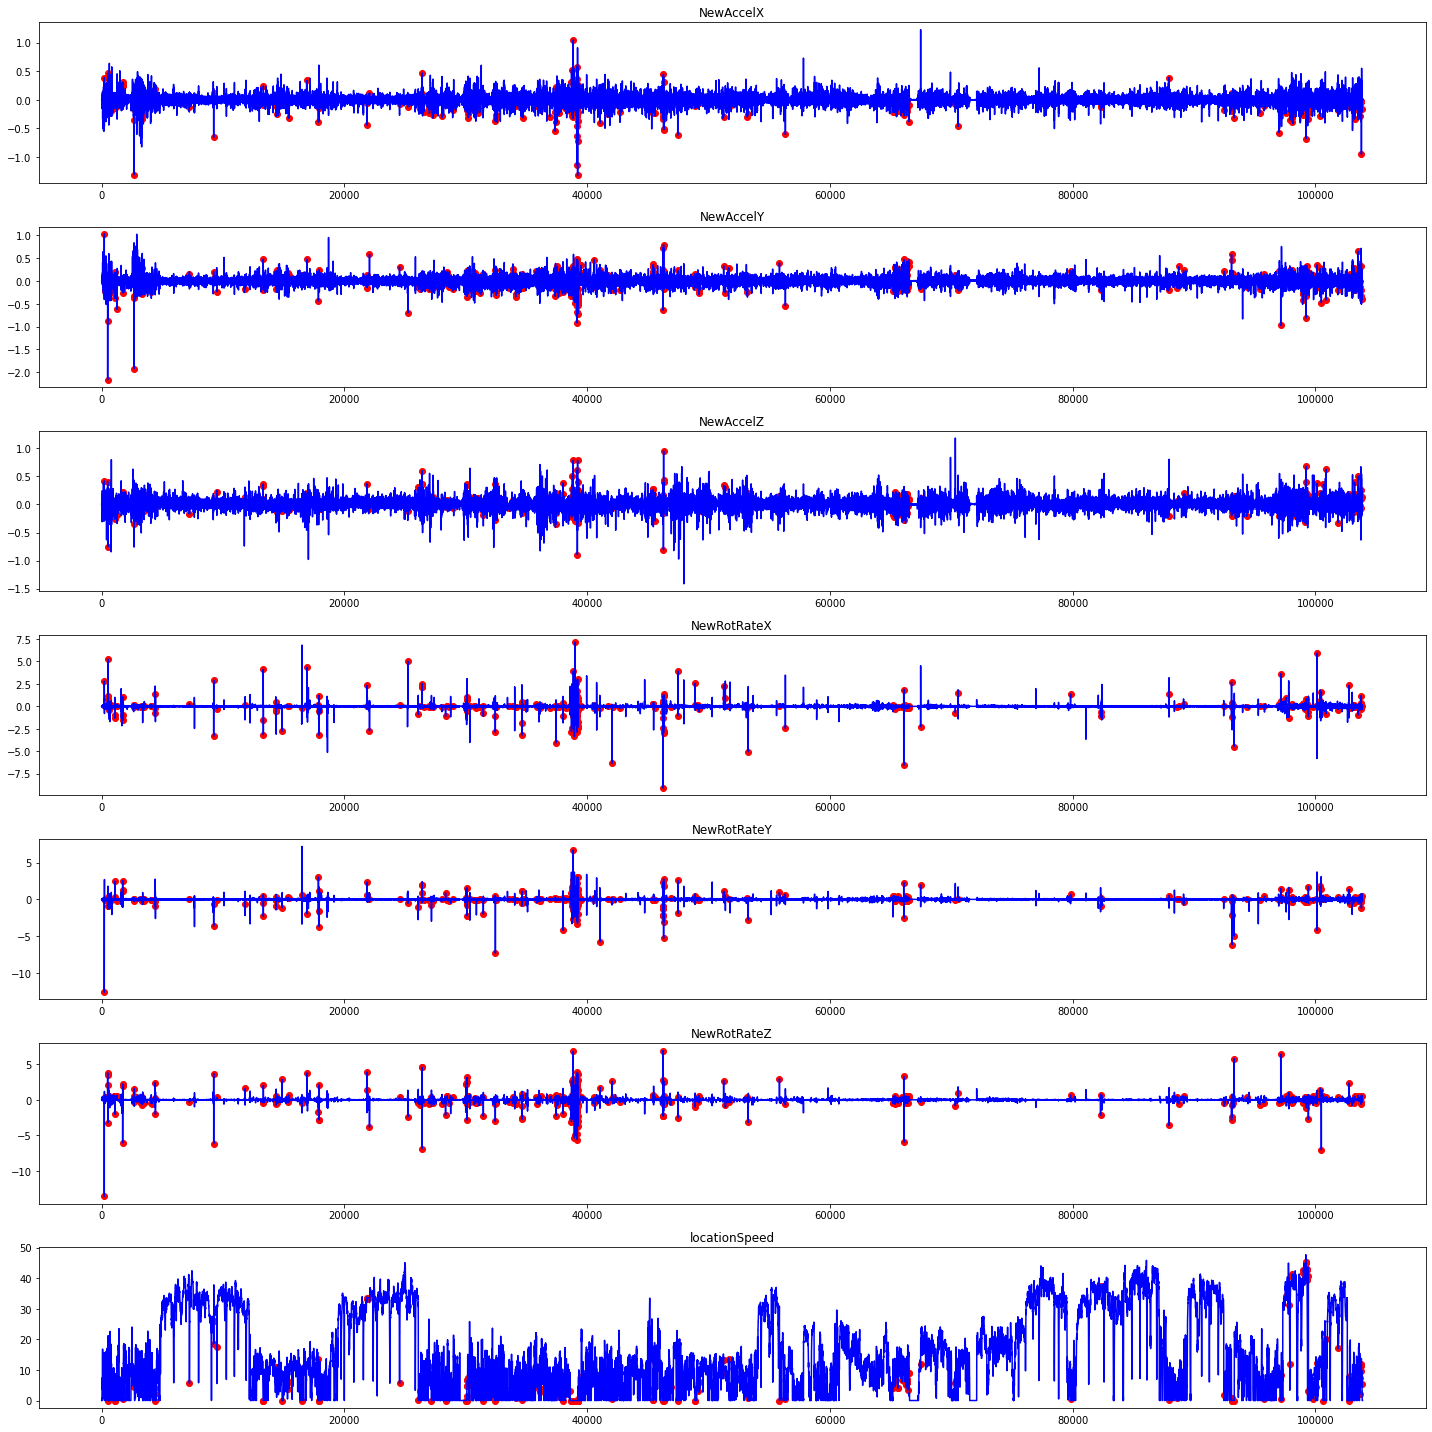

In [23]:
# visualization
fig, axs = plt.subplots(7, 1, figsize=(20,20))
axs = axs.ravel()


def outliers_plot():
    for i in range(7):
        axs[i].plot(df.index, df.iloc[:, i], color='blue', label = 'Normal')
        axs[i].scatter(final_out.index, final_out.iloc[:, i], color='red', label = 'Anomaly')
        axs[i].set_title(df.columns[i])
    plt.tight_layout()
    plt.show()
    return

outliers_plot()

Από τα διαγράμματα, αυτό που θεωρούμε ότι έχει την περισσότερη πληροφορία έιναι το NewRotRateZ και καθαρά με εποπτικό τρόπο θεωρούμε ότι επιλέξαμε σωστές τιμές που αναφέρονται σε extreme turning movements, καθώς οι κόκκινες τελείες που υποδεικνύουν τις έκτοπες τιμές φαίνονται όντως να είναι ακραίες τιμές (εκτός του κύριου όγκου τιμών που το αναμένουμε γύρω από το 0) όπως προέκυψαν από τους παραπάνω κανόνες.

In [28]:
mask = np.isin(data.index, final_out.index) # choose indices for outliers
data.loc[mask, "outlier"] = -1 # put -1 for final_outliers
data.loc[~mask, "outlier"] = 1 # put 1 for inliers
data["outlier"] = data["outlier"].astype(int)
data.to_csv("outlier_detection_harsh_cornering.csv")